In [16]:
import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import timedelta
from importlib import reload
import utils
from sklearn.compose import ColumnTransformer
import column_transforms
from sklearn.inspection import PartialDependenceDisplay



In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [18]:
import shap
import catboost as cb
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm

## Data loading

In [19]:
df = pd.read_csv("features.csv", index_col=[0,1])
df.index = pd.MultiIndex.from_arrays(
    [pd.to_datetime(df.index.get_level_values(0)).date, df.index.get_level_values(1)]
)

Last five years are out of sample and a two year period preceding the out of sample period is used for validation. The ends are exclusive.


In [20]:

beginning_oos = end_validation = datetime.date(2017, 2, 28)
end_oos = datetime.date(2022, 3, 31)
beginning_validation = beginning_oos - timedelta(days=365*2)


## What's the benchmark?

In [21]:
reload(utils)

<module 'utils' from '/Users/mrityunjaisingh/dev_playground/test_230k/230K/utils.py'>

In [22]:
print(f"Using 5y monthly OLS for benchmark")
out_of_sample_mse = utils.value_weighted_mse(df, 'ols_5y_m', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_mape = utils.value_weighted_mape(df, 'ols_5y_m', 'f_ols_1y_d', beginning_oos, end_oos)
print(f"Out of sample MSE: {out_of_sample_mse}")
print(f"Out of sample MAPE: {out_of_sample_mape}")
print(f"Using 1y daily for benchmark")
out_of_sample_mse = utils.value_weighted_mse(df, 'ols_1y_d', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_mape = utils.value_weighted_mape(df, 'ols_1y_d', 'f_ols_1y_d', beginning_oos, end_oos)
print(f"Out of sample MSE: {out_of_sample_mse}")
print(f"Out of sample MAPE: {out_of_sample_mape}")
print(f"Using 3m daily for benchmark")
out_of_sample_mse = utils.value_weighted_mse(df, 'ols_3m_d', 'f_ols_1y_d', beginning_oos, end_oos)
out_of_sample_mape = utils.value_weighted_mape(df, 'ols_3m_d', 'f_ols_1y_d', beginning_oos, end_oos)
print(f"Out of sample MSE: {out_of_sample_mse}")
print(f"Out of sample MAPE: {out_of_sample_mape}")

Using 5y monthly OLS for benchmark
Out of sample MSE: 0.11212827266702115
Out of sample MAPE: 34.09812077664707
Using 1y daily for benchmark
Out of sample MSE: 0.11122707974423018
Out of sample MAPE: 31.478561778962177
Using 3m daily for benchmark
Out of sample MSE: 0.14992244096300256
Out of sample MAPE: 34.23614577135323


We can't use a lagged target because the target itself is a 1 year forward beta, so we can't use a lag smaller than 1 year.

We can't do a ticker wise time series regression, becasue of high dimensionality, we must resort to a full regression across all tickers and dates. We also need to create a forecast column and delete it every time we do a prediction because we need a value weighted metric which can only be calculate by doing a 'group by' by date, so we need to have the forecast(prediction) as a column in the same dataframe structure. 


## Train/validation/test(oos) split

In [23]:
print(df.columns)


Index(['log_size', 'log_bm', 'log_pcf', 'mom', 'strev', 'vol', 'roa', 'roe',
       'log_age_lb', 'price', 'log_to', 'rf', 'rm', 'ols_3m_d', 'ols_1y_d',
       'ols_5y_m', 'f_ols_1y_d', 'market_cap', 'capm_return',
       'log_size_rel_diff', 'log_bm_rel_diff', 'log_pcf_rel_diff',
       'mom_rel_diff', 'strev_rel_diff', 'vol_rel_diff', 'roa_rel_diff',
       'roe_rel_diff', 'log_to_rel_diff', 'ols_3m_d_rel_diff', 'log_price',
       'log_size_diff', 'log_bm_diff', 'log_pcf_diff', 'log_age_lb_diff',
       'log_price_diff', 'log_to_diff'],
      dtype='object')


In [24]:
features_to_use = [
    'log_size',
    'log_bm',
    'log_pcf',
    'mom',
    'strev', 
    'vol', 
    'roa', 
    'roe',
    'log_age_lb', 
    'price', 
    'log_to', 
    'rf', 
    'rm', 
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
]

model = LinearRegression(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use]
df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use]
df['forecast'] = pd.Series(model.predict(df_X_forecast), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)

Validation value weighted MSE: 0.07102189757495873
Validation value weighted MAPE: 25.25580338097608


In [25]:
features_to_use_plus_capm_return = features_to_use + ['market_cap','capm_return',]

model = LinearRegression(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use_plus_capm_return]
df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_plus_capm_return]
df['forecast'] = pd.Series(model.predict(df_X_forecast), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


Validation value weighted MSE: 0.07043886853056938
Validation value weighted MAPE: 24.88330418207413


we know that market_cap and capm return are somewhat useful, let's add column transforms

In [26]:
reload(column_transforms)

<module 'column_transforms' from '/Users/mrityunjaisingh/dev_playground/test_230k/230K/column_transforms.py'>

let's try using zscores

In [27]:
features_to_use_plus_capm_return = features_to_use + ['market_cap','capm_return',]

preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(), features_to_use),   # Standardize numerical columns
    
], remainder = 'passthrough')  

model = LinearRegression(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use_plus_capm_return]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_plus_capm_return]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


Validation value weighted MSE: 0.09162705383984525
Validation value weighted MAPE: 27.85807311274913


That's bad, I guess the reason behind this is that zscores alone are not sufficient, we should have some features that are level based, in order for the regression to work. 

In [28]:
features_to_use_plus_capm_return = features_to_use + ['market_cap','capm_return',]

preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(), features_to_use),   # Standardize numerical columns
    
], remainder = 'passthrough')  

model = LinearRegression(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use_plus_capm_return]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_plus_capm_return]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


Validation value weighted MSE: 0.09162705383984525
Validation value weighted MAPE: 27.85807311274913


That's too many columns to zscore, let's zscore only a few of those columns

In [29]:
features_to_use_plus_capm_return = features_to_use + ['market_cap','capm_return',]

preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(), ['log_to', 'roa', 'roe']),   # Standardize numerical columns
], remainder = 'passthrough')  

model = LinearRegression(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use_plus_capm_return]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_plus_capm_return]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


Validation value weighted MSE: 0.07679432905878675
Validation value weighted MAPE: 25.309484238558714


Let's change the ewm periods

In [30]:
features_to_use_plus_capm_return = features_to_use + ['market_cap','capm_return',]

preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=30, ewm_period_std_dev=30), ['log_to', 'roa', 'roe']),   # Standardize numerical columns
], remainder = 'passthrough')  

model = LinearRegression(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use_plus_capm_return]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_plus_capm_return]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


Validation value weighted MSE: 0.07800593389958968
Validation value weighted MAPE: 25.458918576090923


In [90]:
features_to_use_plus_capm_return = features_to_use + ['market_cap','capm_return',]

preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=30, ewm_period_std_dev=30), ['roa', ]),   # Standardize numerical columns
], remainder = 'passthrough')  

model = LinearRegression(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use_plus_capm_return]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_plus_capm_return]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


Validation value weighted MSE: 0.013184597687616042
Validation value weighted MAPE: 9.643979606451602


Let's try to see if we can winsorize columns to reduce the effect of outliers

In [98]:
reload(column_transforms)

<module 'column_transforms' from '/Users/mrityunjaisingh/dev_playground/230K/column_transforms.py'>

In [97]:
features_to_use_plus_capm_return = features_to_use + ['market_cap','capm_return',]

preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=30, ewm_period_std_dev=30), ['roa', ]),   # Standardize numerical columns
    ('winsorize', column_transforms.Winsorizer(), ['log_bm', 'log_pcf', 'mom', 'strev', 'vol', 'roa', 'roe', 'log_age_lb', 'price', 'log_to', 'rf', 'rm', 'ols_3m_d', 'ols_1y_d', 'ols_5y_m', 'market_cap', 'capm_return']),   # Winsorize numerical columns
], remainder = 'passthrough')  

model = LinearRegression(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use_plus_capm_return]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_plus_capm_return]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


Validation value weighted MSE: 0.024724480349617346
Validation value weighted MAPE: 13.283426260025143


Maybe we should use the cross sectional columsn (the ones which end in rel_diff) to see if they can help me, I believe that they should be helpful, because they signify a reversion to some cross sectional market beta mean, which is a useful thing which I've not tried yet.

In [101]:
df.columns

Index(['log_size', 'log_bm', 'log_pcf', 'mom', 'strev', 'vol', 'roa', 'roe',
       'log_age_lb', 'price', 'log_to', 'rf', 'rm', 'ols_3m_d', 'ols_1y_d',
       'ols_5y_m', 'f_ols_1y_d', 'all null', 'at least one null', 'market_cap',
       'capm_return', 'log_size_rel_diff', 'log_bm_rel_diff',
       'log_pcf_rel_diff', 'mom_rel_diff', 'strev_rel_diff', 'vol_rel_diff',
       'roa_rel_diff', 'roe_rel_diff', 'log_to_rel_diff', 'ols_3m_d_rel_diff',
       'log_price', 'log_size_diff', 'log_bm_diff', 'log_pcf_diff',
       'log_age_lb_diff', 'log_price_diff', 'log_to_diff'],
      dtype='object')

In [15]:

features_to_use_again = [
    'log_size',
    'log_bm',
    'log_pcf',
    'mom',
    'strev', 
    'vol', 
    'roa', 
    'roe',
    'log_age_lb', 
    'price', 
    'log_to', 
    'rf', 
    'rm', 
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
    'market_cap',
    'capm_return'
]


for feature in features_to_use_again:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=7, ewm_period_std_dev=30), [ 'roa', ]),   # Standardize numerical columns
    ('winsorize', column_transforms.Winsorizer(), features_to_use_again),   # Winsorize numerical columns               
], remainder = 'passthrough')  

model = LinearRegression(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use_again]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_again]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


Validation value weighted MSE: 0.07045051450743738
Validation value weighted MAPE: 23.83893652747025


In [121]:

features_to_use_again = [
    'log_size',
    'log_bm',
    'log_pcf',
    'mom',
    'strev', 
    'vol', 
    'roa', 
    'roe',
    'log_age_lb', 
    'price', 
    'log_to', 
    'rf', 
    'rm', 
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
    'market_cap',
    'capm_return'
]


for feature in features_to_use_again:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=7, ewm_period_std_dev=30), [ 'roa','roe', 'price', 'mom' ]),   # Standardize numerical columns
    ('winsorize', column_transforms.Winsorizer(), features_to_use_again),   # Winsorize numerical columns               
], remainder = 'passthrough')  

model = LinearRegression(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use_again]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_again]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


Validation value weighted MSE: 0.011735760215079846
Validation value weighted MAPE: 7.94057387586201


rolling window

We shouldn't trust tuning with rolling window cross validation because there might be overfitting and there's actually a concern about the distribution of beta changing across time, so the {features + hyperparams} that fit , we have to be cautious about this.

In [29]:

features_to_use_again = [
    'log_size',
    'log_bm',
    'log_pcf',
    'mom',
    'strev', 
    'vol', 
    'roa', 
    'roe',
    'log_age_lb', 
    'price', 
    'log_to', 
    'rf', 
    'rm', 
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
    'market_cap',
    'capm_return'
]


for feature in features_to_use_again:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    


dates_index = pd.Series(df.loc[:end_validation, :].index.get_level_values(0).unique(), )


mse_scores = []
mape_scores = []

for train_indices, val_indices, _ in utils.rolling_time_series_split(len(dates_index), 360, 60, 12):
    begin_train_xv = dates_index.loc[train_indices[0]]
    end_train_xv = dates_index.loc[train_indices[-1]]
    begin_validation_xv = dates_index.loc[val_indices[0]]
    end_validation_xv = dates_index.loc[val_indices[-1]]

    preprocessor = ColumnTransformer([
        ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30), [ 'roa','roe', 'price', 'mom' ]),   # Standardize numerical columns
        ('winsorize', column_transforms.Winsorizer(), features_to_use_again),   # Winsorize numerical columns               
    ], remainder = 'passthrough')  
    
    model = LinearRegression(fit_intercept=True)

    df_X_train = df.loc[begin_train_xv:end_train_xv, features_to_use_again]
    df_X_train_transformed = preprocessor.fit_transform(df_X_train)

    df_y_train = df.loc[begin_train_xv:end_train_xv, 'f_ols_1y_d']

    model.fit(df_X_train_transformed, df_y_train)

    # Get the forecast for beginning_validation to end_validation period
    df_X_forecast = df.loc[begin_validation_xv:end_validation_xv, features_to_use_again]

    df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
    df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

    mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    mse_scores.append(mse)
    mape_scores.append(mape)
    df.drop(columns=['forecast'], inplace=True)

print(f"Mean Validation value weighted MSE: {np.mean(np.array(mse_scores))}")
print(f"Mean Validation value weighted MAPE: {np.mean(np.array(mape_scores))}")


Mean Validation value weighted MSE: 0.07034580559991212
Mean Validation value weighted MAPE: 79.82930355801881


expanding window

In [30]:

features_to_use_again = [
    'log_size',
    'log_bm',
    'log_pcf',
    'mom',
    'strev', 
    'vol', 
    'roa', 
    'roe',
    'log_age_lb', 
    'price', 
    'log_to', 
    'rf', 
    'rm', 
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
    'market_cap',
    'capm_return'
]


for feature in features_to_use_again:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    


dates_index = pd.Series(df.loc[:end_validation, :].index.get_level_values(0).unique(), )


mse_scores = []
mape_scores = []

for train_indices, val_indices, _ in utils.expanding_window_time_series_split(len(dates_index), 360, 60, 12):
    begin_train_xv = dates_index.loc[train_indices[0]]
    end_train_xv = dates_index.loc[train_indices[-1]]
    begin_validation_xv = dates_index.loc[val_indices[0]]
    end_validation_xv = dates_index.loc[val_indices[-1]]

    preprocessor = ColumnTransformer([
        ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30), [ 'roa','roe', 'price', 'mom', 'strev' ]),   # Standardize numerical columns
        ('winsorize', column_transforms.Winsorizer(), features_to_use_again),   # Winsorize numerical columns               
    ], remainder = 'passthrough')  
    
    model = LinearRegression(fit_intercept=True)

    df_X_train = df.loc[begin_train_xv:end_train_xv, features_to_use_again]
    df_X_train_transformed = preprocessor.fit_transform(df_X_train)

    df_y_train = df.loc[begin_train_xv:end_train_xv, 'f_ols_1y_d']

    model.fit(df_X_train_transformed, df_y_train)

    # Get the forecast for beginning_validation to end_validation period
    df_X_forecast = df.loc[begin_validation_xv:end_validation_xv, features_to_use_again]

    df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
    df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

    mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    mse_scores.append(mse)
    mape_scores.append(mape)
    df.drop(columns=['forecast'], inplace=True)

print(f"Mean Validation value weighted MSE: {np.mean(np.array(mse_scores))}")
print(f"Mean Validation value weighted MAPE: {np.mean(np.array(mape_scores))}")


Mean Validation value weighted MSE: 0.06929562993000327
Mean Validation value weighted MAPE: 79.02135730888345


We'll just add it to a python script which can be run in the background, so we can do other things while it runs, and so that other teammates can contribute CPU power to this. 


We should also try using some cross validation techniques that Vinicio suggested, maybe something to look in this direction

## Random Forest

In [108]:
reload(column_transforms)

<module 'column_transforms' from '/Users/mrityunjaisingh/dev_playground/230K/column_transforms.py'>

In [126]:

features_to_use_again = [
    'log_size',
    'log_bm',
    'log_pcf',
    'mom',
    'strev', 
    'vol', 
    'roa', 
    'roe',
    'log_age_lb', 
    'price', 
    'log_to', 
    'rf', 
    'rm', 
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
    'market_cap',
    'capm_return'
]


for feature in features_to_use_again:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=7, ewm_period_std_dev=30, append = False), [ 'roa','roe', 'price', 'mom' ]),   
    ('_', column_transforms.Winsorizer(), features_to_use_again),  
], remainder = 'passthrough').set_output(transform = 'pandas')

# model = RandomForestRegressor(max_depth=5, n_estimators=20)
model = RandomForestRegressor(fit_intercept=True)

df_X_train = df.loc[:beginning_validation, features_to_use_again]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)

df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']

model.fit(df_X_train_transformed, df_y_train)

# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_again]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)

df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)

Validation value weighted MSE: 0.011735760215079846
Validation value weighted MAPE: 7.94057387586201


we can look at the effect of features and try do some analysis

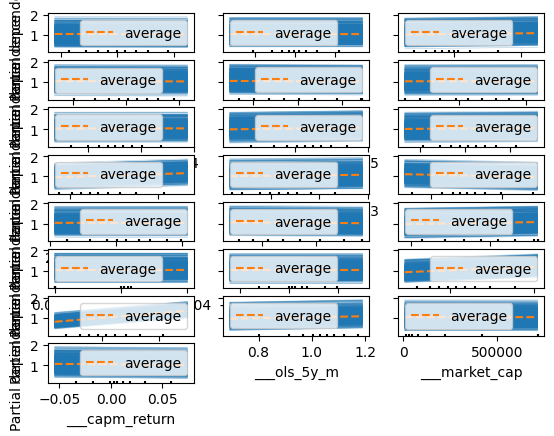

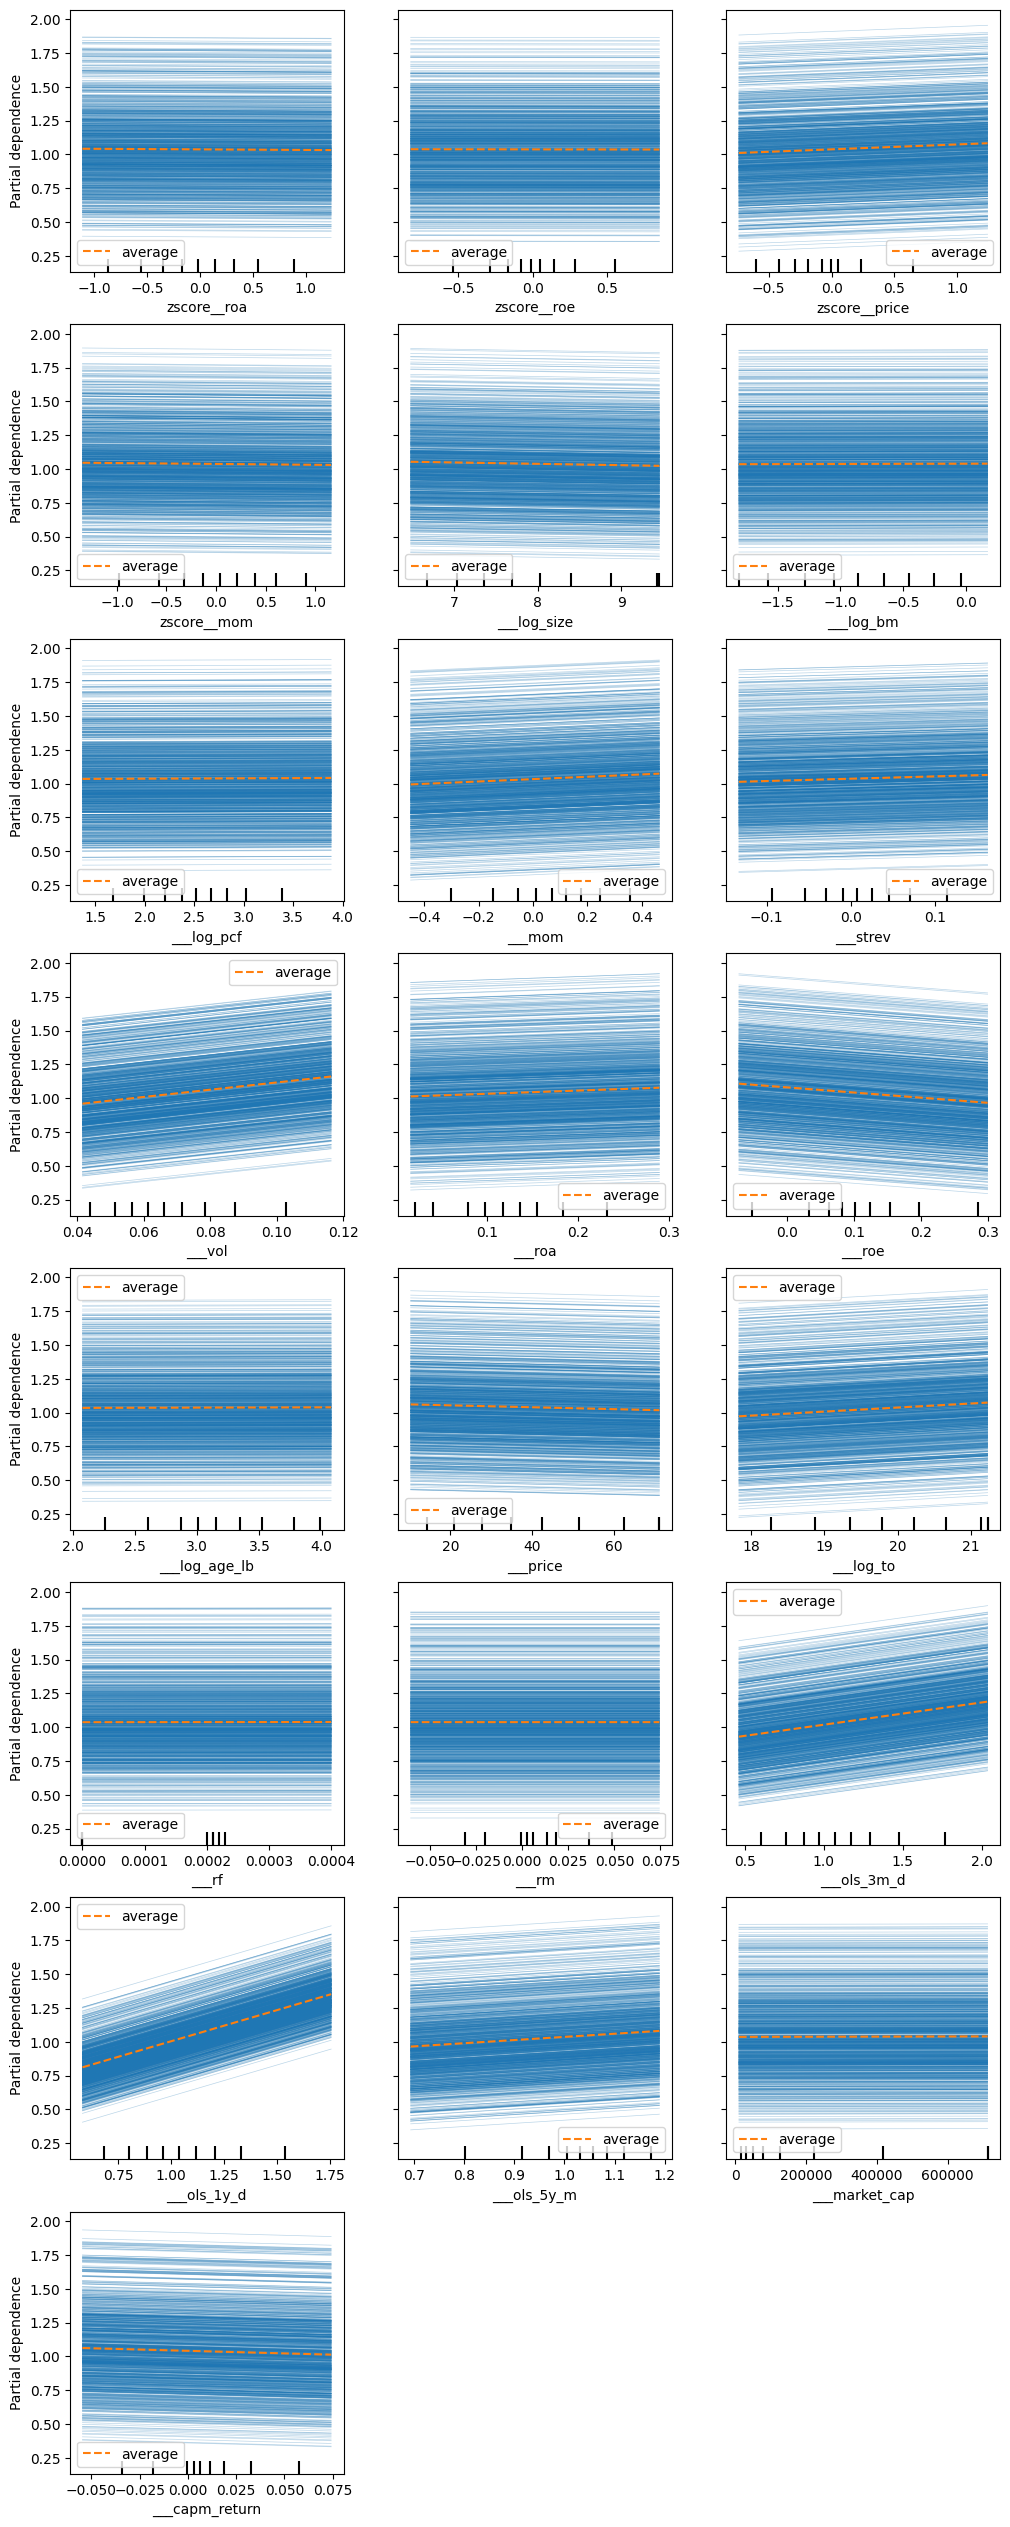

In [138]:

pdp = PartialDependenceDisplay.from_estimator(model, df_X_forecast_transformed, [i for i in range(0,22)], kind = 'both')  # Asset and benchmark returns
plt.figure(figsize=(12, 32))
a = pdp.plot(ax=plt.gca())




rolling window

In [32]:

features_to_use_again = [
    'log_size',
    'log_bm',
    'log_pcf',
    'mom',
    'strev', 
    'vol', 
    'roa', 
    'roe',
    'log_age_lb', 
    'price', 
    'log_to', 
    'rf', 
    'rm', 
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
    'market_cap',
    'capm_return'
]


for feature in features_to_use_again:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break 


dates_index = pd.Series(df.loc[:end_validation, :].index.get_level_values(0).unique(), )


mse_scores = []
mape_scores = []

for train_indices, val_indices, _ in utils.rolling_time_series_split(len(dates_index), 360, 60, 12):
    begin_train_xv = dates_index.loc[train_indices[0]]
    end_train_xv = dates_index.loc[train_indices[-1]]
    begin_validation_xv = dates_index.loc[val_indices[0]]
    end_validation_xv = dates_index.loc[val_indices[-1]]

    preprocessor = ColumnTransformer([
        ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30), [ 'roa','roe', 'price', 'mom' ]),   # Standardize numerical columns
        ('winsorize', column_transforms.Winsorizer(), features_to_use_again),   # Winsorize numerical columns               
    ], remainder = 'passthrough')  
    
    model = RandomForestRegressor(max_depth=5, n_estimators=20)

    df_X_train = df.loc[begin_train_xv:end_train_xv, features_to_use_again]
    df_X_train_transformed = preprocessor.fit_transform(df_X_train)

    df_y_train = df.loc[begin_train_xv:end_train_xv, 'f_ols_1y_d']

    model.fit(df_X_train_transformed, df_y_train)

    # Get the forecast for beginning_validation to end_validation period
    df_X_forecast = df.loc[begin_validation_xv:end_validation_xv, features_to_use_again]

    df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
    df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

    mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    mse_scores.append(mse)
    mape_scores.append(mape)
    df.drop(columns=['forecast'], inplace=True)

print(f"Mean Validation value weighted MSE: {np.mean(np.array(mse_scores))}")
print(f"Mean Validation value weighted MAPE: {np.mean(np.array(mape_scores))}")


Mean Validation value weighted MSE: 1.2514102310030675
Mean Validation value weighted MAPE: 44.31515682643899


expanding window

In [34]:

features_to_use_again = [
    'log_size',
    'log_bm',
    'log_pcf',
    'mom',
    'strev', 
    'vol', 
    'roa', 
    'roe',
    'log_age_lb', 
    'price', 
    'log_to', 
    'rf', 
    'rm', 
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
    'market_cap',
    'capm_return'
]


for feature in features_to_use_again:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    


dates_index = pd.Series(df.loc[:end_validation, :].index.get_level_values(0).unique(), )


mse_scores = []
mape_scores = []

for train_indices, val_indices, _ in utils.expanding_window_time_series_split(len(dates_index), 360, 60, 12):
    begin_train_xv = dates_index.loc[train_indices[0]]
    end_train_xv = dates_index.loc[train_indices[-1]]
    begin_validation_xv = dates_index.loc[val_indices[0]]
    end_validation_xv = dates_index.loc[val_indices[-1]]

    preprocessor = ColumnTransformer([
        ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=12, ewm_period_std_dev=30), [ 'roa','roe', 'price', 'mom', 'strev' ]),   # Standardize numerical columns
        ('winsorize', column_transforms.Winsorizer(), features_to_use_again),   # Winsorize numerical columns               
    ], remainder = 'passthrough')  
    
    model = RandomForestRegressor(max_depth=5, n_estimators=2)

    df_X_train = df.loc[begin_train_xv:end_train_xv, features_to_use_again]
    df_X_train_transformed = preprocessor.fit_transform(df_X_train)

    df_y_train = df.loc[begin_train_xv:end_train_xv, 'f_ols_1y_d']

    model.fit(df_X_train_transformed, df_y_train)

    # Get the forecast for beginning_validation to end_validation period
    df_X_forecast = df.loc[begin_validation_xv:end_validation_xv, features_to_use_again]

    df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
    df['forecast'] = pd.Series(model.predict(df_X_forecast_transformed), index = df_X_forecast.index) # we don't need to reindex the forecast

    mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', begin_validation_xv, end_validation_xv)
    mse_scores.append(mse)
    mape_scores.append(mape)
    df.drop(columns=['forecast'], inplace=True)

print(f"Mean Validation value weighted MSE: {np.mean(np.array(mse_scores))}")
print(f"Mean Validation value weighted MAPE: {np.mean(np.array(mape_scores))}")


Mean Validation value weighted MSE: 9.052739290047672
Mean Validation value weighted MAPE: 45.0131112339487


## LSTM

In [165]:

features_to_use_again = [
    'log_size',
    'log_bm',
    'log_pcf',
    'mom',
    'strev', 
    'vol', 
    'roa', 
    'roe',
    'log_age_lb', 
    'price', 
    'log_to', 
    'rf', 
    'rm', 
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
    'market_cap',
    'capm_return'
]

for feature in features_to_use_again:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=7, ewm_period_std_dev=30, append = False), [ 'roa','roe', 'price', 'mom' ]),   
    ('_', column_transforms.Winsorizer(), features_to_use_again),  
], remainder = 'passthrough').set_output(transform = 'pandas')

df_X_train = df.loc[:beginning_validation, features_to_use_again]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)
df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']
time_steps = 2
forecast_horizon = 1  
batch_size = 16  
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=df_X_train_transformed,  # Input data (exclude last steps)
    targets=df_y_train[(time_steps - 1):],  # Target is the next time step(s)
    sequence_length=time_steps,
    batch_size=batch_size
)

# model = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(10, df_X_train_transformed.shape[1])),
#     Dropout(0.2),
#     LSTM(30, return_sequences=False),
#     Dropout(0.2),
#     Dense(1, activation='linear')
# ])
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(10, df_X_train_transformed.shape[1])),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model.compile(loss='mse', optimizer='adam')
epochs, batch_size = 1, 54
# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_again]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
model.fit(dataset, epochs=epochs, batch_size=batch_size)


41291/41291 [==============================] - 46s 1ms/step - loss: 34.9237


In [163]:
forecast_horizon = 1
time_steps = 2

dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=df_X_forecast_transformed,  # Input data (exclude last steps)
    targets=None,  # Target is the next time step(s)
    sequence_length=time_steps,
    batch_size=batch_size
)

predictions = model.predict(dataset)


df['forecast'] = pd.Series(predictions.flatten(), index = df_X_forecast_transformed.index[(time_steps - 1): ]) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


682/682 [==============================] - 1s 1ms/step
Validation value weighted MSE: 0.030396632870309536
Validation value weighted MAPE: 16.280733758778638


It's best to abandon using shap and partial dependence for LSTM, because of hte input structure reasons

In [164]:

pdp = PartialDependenceDisplay.from_estimator(model, dataset, [i for i in range(0,22)], kind = 'both')  # Asset and benchmark returns
plt.figure(figsize=(12, 32))
a = pdp.plot(ax=plt.gca())


ValueError: Expected 2D array, got scalar array instead:
array=<_BatchDataset element_spec=TensorSpec(shape=(None, None, 22), dtype=tf.float64, name=None)>.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

we should rather focus on using a dense neural network

In [166]:

features_to_use_again = [
    'log_size',
    'log_bm',
    'log_pcf',
    'mom',
    'strev', 
    'vol', 
    'roa', 
    'roe',
    'log_age_lb', 
    'price', 
    'log_to', 
    'rf', 
    'rm', 
    'ols_3m_d', 
    'ols_1y_d',
    'ols_5y_m', 
    'market_cap',
    'capm_return'
]

for feature in features_to_use_again:
    if feature not in df.columns:
        print(f"Missing {feature}")
        break
    
preprocessor = ColumnTransformer([
    ('zscore', column_transforms.ZscoreTransformer(ewm_period_m=7, ewm_period_std_dev=30, append = False), [ 'roa','roe', 'price', 'mom' ]),   
    ('_', column_transforms.Winsorizer(), features_to_use_again),  
], remainder = 'passthrough').set_output(transform = 'pandas')

df_X_train = df.loc[:beginning_validation, features_to_use_again]
df_X_train_transformed = preprocessor.fit_transform(df_X_train)
df_y_train = df.loc[:beginning_validation, 'f_ols_1y_d']
time_steps = 2
forecast_horizon = 1  
batch_size = 16  
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=df_X_train_transformed,  # Input data (exclude last steps)
    targets=df_y_train[(time_steps - 1):],  # Target is the next time step(s)
    sequence_length=time_steps,
    batch_size=batch_size
)

# model = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(10, df_X_train_transformed.shape[1])),
#     Dropout(0.2),
#     LSTM(30, return_sequences=False),
#     Dropout(0.2),
#     Dense(1, activation='linear')
# ])
model = Sequential([
    Dense(50, activation='relu', input_shape=(df_X_train_transformed.shape[1],)),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model.compile(loss='mse', optimizer='adam')
epochs, batch_size = 1, 54
# Get the forecast for beginning_validation to end_validation period
df_X_forecast = df.loc[beginning_validation:end_validation, features_to_use_again]
df_X_forecast_transformed = preprocessor.transform(df_X_forecast)
model.fit(dataset, epochs=epochs, batch_size=batch_size)


41291/41291 [==============================] - 24s 571us/step - loss: 842124.6250


In [167]:
predictions = model.predict(df_X_forecast_transformed)


df['forecast'] = pd.Series(predictions.flatten(), index = df_X_forecast_transformed.index) # we don't need to reindex the forecast

mse = utils.value_weighted_mse(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
mape = utils.value_weighted_mape(df, 'forecast', 'f_ols_1y_d', beginning_validation, end_validation)
print(f"Validation value weighted MSE: {mse}")
print(f"Validation value weighted MAPE: {mape}")
df.drop(columns=['forecast'], inplace=True)


1150/1150 [==============================] - 0s 224us/step
Validation value weighted MSE: 0.026098781359907966
Validation value weighted MAPE: 14.706117025689492


# XGBoost

### Features selection 1

In [16]:
y_target = "f_ols_1y_d"
L_features = list(df_train.columns)
L_features.remove(y_target)

### Train and validation of the model

In [17]:
df_X_train = df_train[L_features]
df_y_train = df_train[[y_target]]

df_X_validation = df_validation[L_features]
df_y_validation = df_validation[[y_target]]

In [18]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(df_X_train, df_y_train)

y_pred_train = xgb_model.predict(df_X_train).flatten()
y_pred_validation = xgb_model.predict(df_X_validation).flatten()

In [19]:
compute_metrics(df_y_train.values.flatten(), df_y_validation.values.flatten(), y_pred_train, y_pred_validation)

,MSE train,MAPE train,MSE val,MAPE val
0,0.073581,30.515906,0.152817,29.225004


# LSTM

### Features selection 1

In [24]:
y_target = "f_ols_1y_d"
L_features = df_train.filter(like="norm", axis=1).columns
#### MinMaxScaler is better for neural net

### Train and validation of the model

In [17]:
df_X_train = df_train[L_features]
df_y_train = df_train[[y_target]]

df_X_validation = df_validation[L_features]
df_y_validation = df_validation[[y_target]]

In [18]:
seq_length = 10 

lstm_model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(seq_length, 1)),
    Dense(1)  # Output layer
])

lstm_model.compile(optimizer="adam", loss="mse")

lstm_model.fit(df_X_train, df_y_train, epochs=10, batch_size=16, validation_data=(df_X_validation, df_y_validation))

y_pred_train = lstm_model.predict(df_X_train).flatten()
y_pred_validation = lstm_model.predict(df_X_validation).flatten()

Epoch 1/10
31618/31618 ━━━━━━━━━━━━━━━━━━━━ 709s 22ms/step - loss: 33551.0195 - val_loss: 83.1450
Epoch 2/10
31618/31618 ━━━━━━━━━━━━━━━━━━━━ 539s 17ms/step - loss: 349.9625 - val_loss: 0.2979
Epoch 3/10
31618/31618 ━━━━━━━━━━━━━━━━━━━━ 492s 16ms/step - loss: 40.9541 - val_loss: 25.7837
Epoch 4/10
31618/31618 ━━━━━━━━━━━━━━━━━━━━ 492s 16ms/step - loss: 262.3614 - val_loss: 475.3060
Epoch 5/10
31618/31618 ━━━━━━━━━━━━━━━━━━━━ 503s 16ms/step - loss: 31864860.0000 - val_loss: 499.0799
Epoch 6/10
31618/31618 ━━━━━━━━━━━━━━━━━━━━ 506s 16ms/step - loss: 4489.5107 - val_loss: 0.2148
Epoch 7/10
31618/31618 ━━━━━━━━━━━━━━━━━━━━ 502s 16ms/step - loss: 5524.8208 - val_loss: 9852.0693
Epoch 8/10
31618/31618 ━━━━━━━━━━━━━━━━━━━━ 499s 16ms/step - loss: 421.2025 - val_loss: 0.2024
Epoch 9/10
31618/31618 ━━━━━━━━━━━━━━━━━━━━ 501s 16ms/step - loss: 633.2845 - val_loss: 2.4086
Epoch 10/10
31618/31618 ━━━━━━━━━━━━━━━━━━━━ 514s 16ms/step - loss: 1405798.0000 - val_loss: 1264.6115
15809/15809 ━━━━━━━━━━━━━

In [19]:
compute_metrics(df_y_train.values.flatten(), df_y_validation.values.flatten(), y_pred_train, y_pred_validation)

,MSE train,MAPE train,MSE val,MAPE val
0,167.993353,inf,1264.611572,530.977501


# Additional model: CatBoost (automatic variable selection)

In [152]:
y_target = "f_ols_1y_d"
L_features = df_train.filter(like="norm", axis=1).columns

In [153]:
df_X_train = df_train[L_features]
df_y_train = df_train[[y_target]]

df_X_validation = df_validation[L_features]
df_y_validation = df_validation[[y_target]]

In [155]:
train_pool = cb.Pool(df_X_train, df_y_train)
validation_pool  = cb.Pool(df_X_validation, df_y_validation)

In [156]:
catboost_model = cb.CatBoostRegressor(loss_function="RMSE", verbose=False)
catboost_model.fit(train_pool, eval_set=validation_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [157]:
y_pred_train = catboost_model.predict(train_pool)
y_pred_validation = catboost_model.predict(validation_pool)

In [160]:
compute_metrics(df_y_train.values.flatten(), df_y_validation.values.flatten(), y_pred_train, y_pred_validation)

,MSE train,MAPE train,MSE val,MAPE val
0,0.220727,63.609222,0.333766,41.177067


In [163]:
model = CatBoostRegressor(iterations=900, random_seed=0)
summary = model.select_features(
    train_pool,
    eval_set=validation_pool,
    features_for_select='0-12', 
    num_features_to_select=1,  
    steps=1, 
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True, # The only parameter that can be selected based on cross-validation is the number of iterations. Select the best iteration based on the information of the cv results and train the final model with this number of iterations.
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Interpretation of the best model (XGBoost for the moment)

In [20]:
y_target = "f_ols_1y_d"
L_features = list(df_train.columns)
L_features.remove(y_target)
df_X_train = df_train[L_features]
df_y_train = df_train[[y_target]]

df_X_validation = df_validation[L_features]
df_y_validation = df_validation[[y_target]]

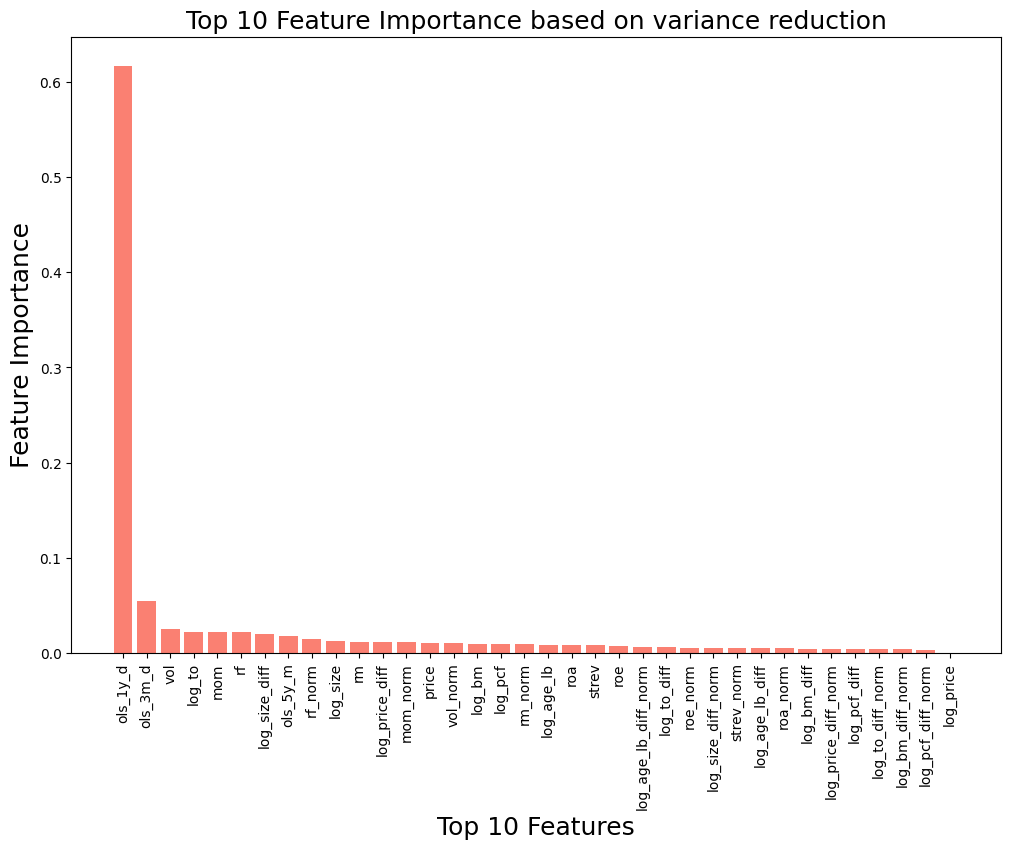

In [21]:
plt.figure(figsize=(12, 8))

sorted_feature_importance = xgb_model.feature_importances_.argsort()[::-1]

plt.bar(df_X_train.columns[sorted_feature_importance], 
        xgb_model.feature_importances_[sorted_feature_importance], 
        color='salmon')

plt.xticks(rotation=90)


plt.ylabel('Feature Importance', fontsize=18)
plt.xlabel('Top 10 Features', fontsize=18)
plt.title('Top 10 Feature Importance based on variance reduction', fontsize=18)

plt.show()

In [22]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(df_X_train)

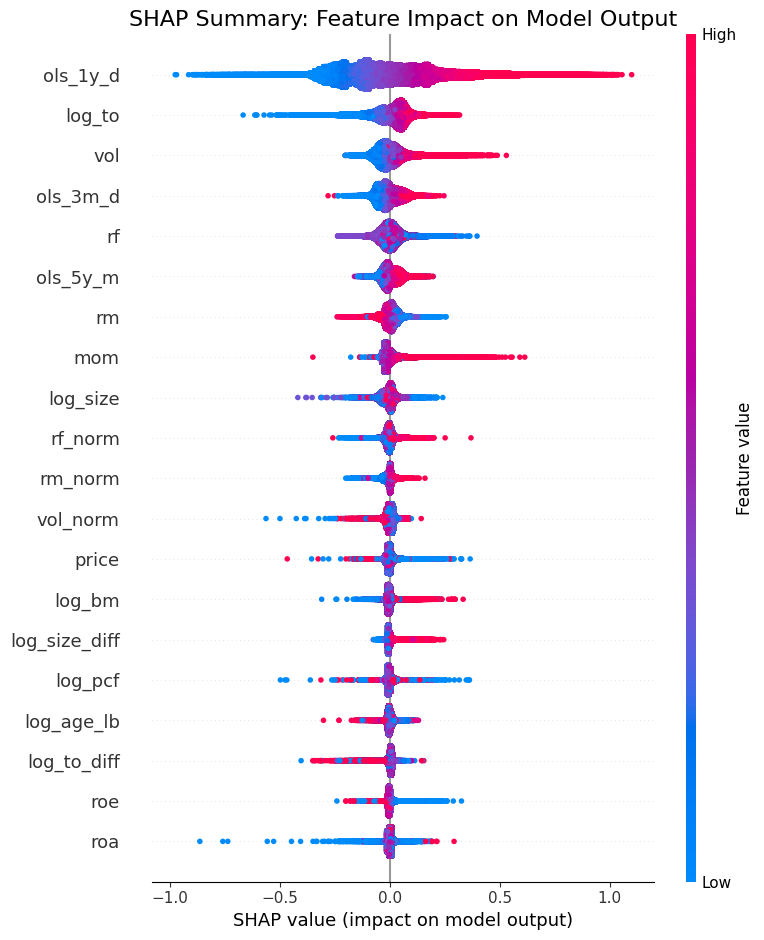

In [23]:
plt.title('SHAP Summary: Feature Impact on Model Output', fontsize=16)

shap.summary_plot(shap_values, df_X_train)

# Model selection